In [1]:
import os
import csv
import time
import platform
import datetime
import pandas as pd
import networkx as nx
from graph_partitioning import GraphPartitioning, utils

cols = ["WASTE", "CUT RATIO", "EDGES CUT", "TOTAL COMM VOLUME", "MODULARITY", "LONELINESS", "NETWORK PERMANENCE", "NORM. MUTUAL INFO"]
pwd = %pwd

# [] networkkit PermanenceCentrality - check maxperm works with sorted nodes
# [] add f-score before relabeling + fscore after relabeling metric (delta between the two)
# [] (scale virtual node weight * percentage of highest partition score at the moment and update the virtual node weight)
# [] automatic detection of edgelist/metis
# [] stability?
# [] add Random generated dataset
# [] test size & density of networks: test if fennel is better always or certain network setups
# [] randomize order of people, everyone arrives if no file there
# [] setup computer ready
# [] send: experiement plots, ask what was expected output/behaviour + new experiments list
# [] NDA/IP
# [] STATS fennel reoerdering centrality = minimal population size
# [] centrality: impact on SCOTCH + PATOH
# [] centrality: everyone people batch, 1.0 node and edge weight, everyone arrives
# [x] edge weights for people + new metric for cost of cutting valuable edges
# [x] generate edge weights
# [] hyperedge expansion for patoh: look at different approaches


'''
1. edge weights
2. new metrics - + random generated datasets
3. experiments
4. centrality stuff - stats functions/equations used at the moment to compute the scores for centralities

'''


# parametrized config
parametrized_config = {
    "DATA_FILENAME": os.path.join(pwd, "data", "predition_model_tests", "network", "network_#networkID#.txt"),
    "OUTPUT_DIRECTORY": os.path.join(pwd, "output"),

    # Set which algorithm is run for the PREDICTION MODEL.
    # Either: 'FENNEL' or 'SCOTCH'
    "PREDICTION_MODEL_ALGORITHM": "",

    # Alternativly, read input file for prediction model.
    # Set to empty to generate prediction model using algorithm value above.
    "PREDICTION_MODEL": "",

    
    "PARTITIONER_ALGORITHM": "",

    # File containing simulated arrivals. This is used in simulating nodes
    # arriving at the shelter. Nodes represented by line number; value of
    # 1 represents a node as arrived; value of 0 represents the node as not
    # arrived or needing a shelter.
    "SIMULATED_ARRIVAL_FILE": os.path.join(pwd,
                                           "data",
                                           "predition_model_tests",
                                           "dataset_1_shift_rotate",
                                           "simulated_arrival_list",
                                           "percentage_of_prediction_correct_#correctedness#",
                                           "arrival_#correctedness#_#networkID#.txt"
                                          ),
    
    # File containing the prediction of a node arriving. This is different to the
    # simulated arrivals, the values in this file are known before the disaster.
    "PREDICTION_LIST_FILE": os.path.join(pwd,
                                         "data",
                                         "predition_model_tests",
                                         "dataset_1_shift_rotate",
                                         "prediction_list",
                                         "prediction_#networkID#.txt"
                                        ),

    # File containing the geographic location of each node, in "x,y" format.
    "POPULATION_LOCATION_FILE": os.path.join(pwd,
                                             "data",
                                             "predition_model_tests",
                                             "coordinates",
                                             "coordinates_#networkID#.txt"
                                            ),

    # Number of shelters
    "num_partitions": 6,

    # The number of iterations when making prediction model
    "num_iterations": 1,

    # Percentage of prediction model to use before discarding
    # When set to 0, prediction model is discarded, useful for one-shot
    "prediction_model_cut_off": 0.10,

    # Alpha value used in one-shot (when restream_batches set to 1)
    "one_shot_alpha": 0.5,

    # Number of arrivals to batch before recalculating alpha and restreaming.
    # When set to 1, one-shot is used with alpha value from above
    "restream_batches": 10,

    # When the batch size is reached: if set to True, each node is assigned
    # individually as first in first out. If set to False, the entire batch
    # is processed and empty before working on the next batch.
    "sliding_window": False,

    # Create virtual nodes based on prediction model
    "use_virtual_nodes": False,

    # Virtual nodes: edge weight
    "virtual_edge_weight": 1.0,

    # Loneliness score parameter. Used when scoring a partition by how many
    # lonely nodes exist.
    "loneliness_score_param": 1.2,

    ####
    # GRAPH MODIFICATION FUNCTIONS

    # Also enables the edge calculation function.
    "graph_modification_functions": True,

    # If set, the node weight is set to 100 if the node arrives at the shelter,
    # otherwise the node is removed from the graph.
    "alter_arrived_node_weight_to_100": False,

    # Uses generalized additive models from R to generate prediction of nodes not
    # arrived. This sets the node weight on unarrived nodes the the prediction
    # given by a GAM.
    # Needs POPULATION_LOCATION_FILE to be set.
    "alter_node_weight_to_gam_prediction": False,

    # The value of 'k' used in the GAM will be the number of nodes arrived until
    # it reaches this max value.
    "gam_k_value": 100,

    # Alter the edge weight for nodes that haven't arrived. This is a way to
    # de-emphasise the prediction model for the unknown nodes.
    "prediction_model_emphasis": 1.0,
    
    # This applies the prediction_list_file node weights onto the nodes in the graph
    # when the prediction model is being computed and then removes the weights
    # for the cutoff and batch arrival modes
    "apply_prediction_model_weights": True,
    
    # Path to the scotch shared library
    "SCOTCH_LIB_PATH": os.path.join(pwd, "libs/scotch/macOS/libscotch.dylib")
    if 'Darwin' in platform.system()
    else "/usr/local/lib/libscotch.so",
    
    # Path to the PaToH shared library
    "PATOH_LIB_PATH": os.path.join(pwd, "libs/patoh/lib/macOS/libpatoh.dylib")
    if 'Darwin' in platform.system()
    else os.path.join(pwd, "libs/patoh/lib/linux/libpatoh.so"),
    
    "PATOH_ITERATIONS": 5,

    # Alters how much information to print. Keep it at 1 for this notebook.
    # 0 - will print nothing, useful for batch operations.
    # 1 - prints basic information on assignments and operations.
    # 2 - prints more information as it batches arrivals.
    "verbose": 0
}

#gp = GraphPartitioning(config)

# Optional: shuffle the order of nodes arriving
# Arrival order should not be shuffled if using GAM to alter node weights
#random.shuffle(gp.arrival_order)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import experiments.io as expIO
import experiments.utils as expUtils

def runPartitioning(config, outFilePath, numPartitions, networkID):
    start_time = time.time()
    
    gp = GraphPartitioning(config)
    
    outFile = expIO.OutFile(outFilePath)
    expIO.writeConfig(outFile, config, numPartitions, networkID)
    
    gp.load_network()
    gp.init_partitioner()
    
    m = gp.prediction_model()
    expIO.writePartitionStats(outFile, "prediction_model", gp, m)
        
    m = gp.assign_cut_off()
    expIO.writePartitionStats(outFile, "cutoff", gp, m)

    m = gp.batch_arrival()
    expIO.writePartitionStats(outFile, "batch_arrivals", gp, m)
    
    outFile.write("Experiment duration = " + str(time.time() - start_time))
    outFile.save()
    
    del m
    del gp
    del outFile
    
def runPartitioningNoStorage(config, numPartitions, networkID):
    start_time = time.time()
    
    gp = GraphPartitioning(config)    
    gp.load_network()
    gp.init_partitioner()
    
    m = gp.prediction_model()
    m = gp.assign_cut_off()
    m = gp.batch_arrival()
        
    del m
    del gp

In [9]:
from sklearn.metrics import f1_score
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.cluster import normalized_mutual_info_score

import time 

def relabel(array, v1, v2):
    newArr = []
    for val in array:
        if(val == v1):
            newArr.append(v2)
        elif (val == v2):
            newArr.append(v1)
        else:
            newArr.append(val)
    return newArr

#test = [0,0,1,1,2,2]
#print(relabel(test, 0, 0))

testNMIRelabeling = True
if testNMIRelabeling:
    num_partitions = 4
    config = expUtils.getConfig(parametrized_config, "PATOH", num_partitions, 100, 0.0, 1, False, False, False)
    
    gp = GraphPartitioning(config)    
    gp.load_network()
    gp.init_partitioner()

    m = gp.prediction_model()

    predictionModel = np.array(gp.assignments, copy=True)

    m = gp.assign_cut_off()
    m = gp.batch_arrival()
    
    batchModel = np.array(gp.assignments, copy=True)
    
    pm = []
    batch = []
    for i, partition in enumerate(batchModel):
        if partition >= 0:
            pm.append(predictionModel[i])
            batch.append(partition)
            
    prediction = np.array(pm)
    batch = np.array(batch)
    
    startt = time.time()
    
    print("Prediction Model", prediction)
    print("Batch Arrivals", batch)
    
    print("NMI:", normalized_mutual_info_score(prediction, batch))
    print("fscore:",f1_score(prediction, batch, average='weighted'))

    fscores = []
    fscores_correct = []

    for i in range(0, num_partitions):
        fi = []
        fi_correct = []
        for j in range(0, num_partitions):
            batch_ij = relabel(batch, i, j)
            fi.append(1.0 - f1_score(prediction, batch_ij, average='weighted'))
            fi_correct.append(f1_score(prediction, batch_ij, average='weighted'))
        fscores.append(fi)
        fscores_correct.append(fi_correct)
        
    
    print('fscore Matrix:', fscores_correct)

    cost = np.array(fscores) 
    row_ind, col_ind = linear_sum_assignment(cost)
    print('Hungarian rows', row_ind)
    print('Hungarian cols', col_ind)
    
    relabelled_batch = batch
    
    relabel_done = {}
    for i, row in enumerate(row_ind):
        # check if done already        
        col = col_ind[i]
        if col == row:
            continue

        if(col < row):
            if col in relabel_done:
                #if row in relabel_done[col]:
                continue
            relabel_done[col] = row
        else:
            if row in relabel_done:
                continue
            relabel_done[row] = col
        
            
        print(row, '->', col)
        relabelled_batch = relabel(relabelled_batch, row, col_ind[i])
        print("nmi:", normalized_mutual_info_score(prediction, relabelled_batch))
        print("relabelled batch:", np.array(relabelled_batch))
        print("fscore relabelled:",f1_score(prediction, relabelled_batch, average='weighted'))
    print("elapsed = ", time.time() - startt)

        
    print("NMI relabelled:", normalized_mutual_info_score(prediction, relabelled_batch))
    print("fscore relabelled:",f1_score(prediction, relabelled_batch, average='weighted'))

    del gp
    del m
    del predictionModel



Prediction Model [3 2 1 3 0 3 0 1 2 2 2 1 0 1 0 0 1 1 3 3 3 0 0 3 2 0 1 2 1 2 2 3 2 3 1 0 2
 1 2 2 1 2 1 0 1 1 1 2 1 0 0 1 1 2 0 1 3 0 3 1 0 3 1 1 3 0 2 2 1 1 0 3 3 1
 1 3 3 3 0 3 0 0 1 3 1 0 2 3 2 3 3 1 1 2 0 1 1 0 3 0 0 0 0 3 0 1 2 3 3 1 3
 1 1 0 2 0 2 3 0 3 0 1 0 2 1 2 1 2 0 2 1 0 3 2 3 1 2 1 0 0 3 3 0 2 1 2 2 1
 3 3 2 0 3 0 0 1 3 0 0 2 0 0 3 0 0 2 1 1 0 2 1 1 0 3 3 2 1 3 0 0 2 0 1 2 3
 3 2 3 3 0 2 1 3 0 0 2 0 2 2 1 2 0 0 0 3 2 1 2 0 2 0 2 3 0 2 2 1 2 0 2 1 1
 0 2 3 1 0 2 2 0 3 2 3 2 3 3 3 3 3 3 3 0 1 3 1 1 2 2 3 2 3 0 2 2 0 1 1 3 2
 1 1 3 2 0 2 3 0 0 2 1 1 2 0 3 1 0 3 0 2 3 2]
Batch Arrivals [3 1 2 0 2 0 3 1 2 0 3 1 3 1 2 0 3 1 2 0 0 1 2 3 0 3 2 1 2 0 2 3 3 1 1 2 0
 1 0 3 1 3 2 0 1 2 1 1 3 2 0 1 2 0 3 3 0 3 0 2 2 0 3 1 3 2 0 0 1 2 2 0 3 1
 1 1 0 3 3 2 1 3 2 0 1 2 0 2 3 0 2 1 3 3 3 1 1 0 1 2 2 0 2 1 3 3 1 0 2 1 0
 1 3 3 0 2 0 2 3 0 3 2 3 1 1 1 1 2 1 2 3 0 0 1 3 2 1 1 0 2 0 0 3 2 1 3 3 1
 2 0 0 1 3 3 0 2 0 2 3 3 0 3 0 1 3 1 2 3 2 1 1 1 2 0 2 0 2 3 2 1 3 0 1 1 2
 0 1 3 0 2 0 1 3 2 2 3

In [10]:
# All possible ways to run the experiments
all_algorithms = ["FENNEL", "SCOTCH", "PATOH"]

all_correctedness = expUtils.fillRange(0, 11, expUtils.times10)
all_partitions = expUtils.fillRange(4, 13)
all_networks = expUtils.fillRange(1, 1001)
all_predictionModelCutoff = expUtils.fillRange(0, 21, expUtils.cutoffValueFunc)

storeResults = True

all_slidingWindow = [True, False]
all_virtualNodes = [True, False]
all_GAMModel = [True, False]

In [17]:
# EXPERIMENT 1: how does changing the cutoff on prediction model, alter how well partitions can be made

# todo avoid double experiments, cutoff, size of batch
# todo check edgescut = subset of population

# pick a subset of settings, if needed
algorithms = all_algorithms
#partitions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
partitions = [4]
correctedness = [100]
predictionModelCutoff = [0.0]
#predictionModelCutoff = expUtils.fillRange(0, 21, expUtils.cutoffValueFunc)
networks = [1]
slidingWindows = [False]
virtualNodes = [True, False]
#GAMModels = [True, False]

outputDir = expUtils.experimentDir(parametrized_config)
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

experimentCount = 0
experimentTimes = []

dontRunExperiments = False # safety net to avoid overwriting experiments
for algorithm in algorithms:
    # run the experiment separately for each algorithm
    if dontRunExperiments == True:
        break
        
    for partition in partitions:
        # run the experiment with differnt number of partitions
        for correct in correctedness:
            # run the experiment for different correctedness predictions
            for cutoff in predictionModelCutoff:
                # this is the real experiment - different cutoff values
                for network in networks:
                    # sliding window
                    for sliding in slidingWindows:
                        # virtual nodes
                        for virtualNode in virtualNodes:
                            # GAM
                            for GAMModel in GAMModels:
                                start_time = time.time()

                                # setup the experiment
                                config = expUtils.getConfig(parametrized_config, algorithm, partition, correct, cutoff, network, sliding, virtualNode, GAMModel)

                                outFN = expUtils.getOutFileName(algorithm, partition, correct, cutoff, network, sliding, virtualNode, GAMModel)
                                outfPath = os.path.join(outputDir, outFN)
                                #with open(outfPath, 'w+') as experimentFile:
                                    # run experiment and store results
                                runPartitioning(config, outfPath, partition, network)
                                
                                elapsed_time = time.time() - start_time
                                print("Experiment", experimentCount, elapsed_time, outFN)
                                experimentTimes.append(elapsed_time)
                                experimentCount += 1

expUtils.purgeEmptyDir(outputDir)

Creating virtual nodes and assigning edges based on prediction model

Virtual nodes:
Experiment 0 4.941254138946533 FENNEL_p4_c100_cutoff0_sw0_vn1_gam0_1.txt
Experiment 1 3.9470372200012207 FENNEL_p4_c100_cutoff0_sw0_vn0_gam0_1.txt
Creating virtual nodes and assigning edges based on prediction model

Virtual nodes:
Experiment 2 11.844391822814941 SCOTCH_p4_c100_cutoff0_sw0_vn1_gam0_1.txt
Experiment 3 9.083883047103882 SCOTCH_p4_c100_cutoff0_sw0_vn0_gam0_1.txt
Creating virtual nodes and assigning edges based on prediction model

Virtual nodes:
Experiment 4 4.8479530811309814 PATOH_p4_c100_cutoff0_sw0_vn1_gam0_1.txt
Experiment 5 3.7463691234588623 PATOH_p4_c100_cutoff0_sw0_vn0_gam0_1.txt


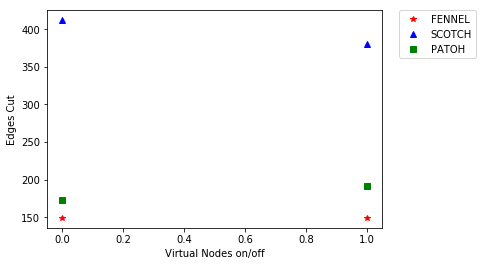

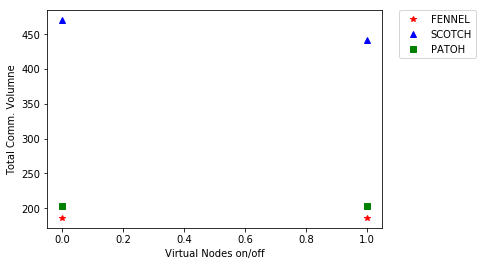

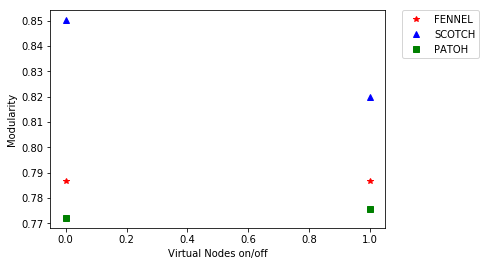

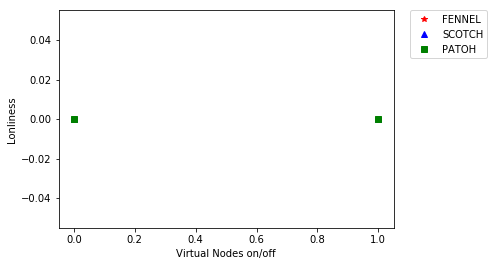

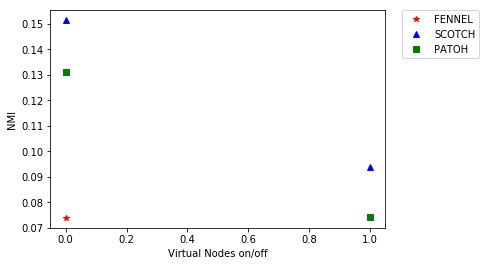

In [19]:
# experiment for prediction model cutoff

algorithms = all_algorithms
correctedness = [100]
networks = [1]
slidingWindows = [False]
virtualNodes = [False]
GAMModels = [False]


'''
resultsDir = os.path.join(parametrized_config['OUTPUT_DIRECTORY'], "17_04_27", "10_56_16")
partitions = [4]
predictionModelCutoff = expUtils.fillRange(0, 21, expUtils.cutoffValueFunc)
xlabel = "Prediction Model Cut-off"
x = []
for p in predictionModelCutoff:
    x.append(p * 10)

# experiment for partition size - no prediction model
resultsDir = os.path.join(parametrized_config['OUTPUT_DIRECTORY'], "17_04_27", "11_04_09")
partitions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
predictionModelCutoff = [0.0]
xlabel = "Number of Partitions"
x=partitions
'''


# experiment for virtual nodes
resultsDir = os.path.join(parametrized_config['OUTPUT_DIRECTORY'], "17_04_27", "14_49_14")
partitions = [4]
predictionModelCutoff = [0.0]
xlabel = "Virtual Nodes on/off"
virtualNodes = [False, True]
x=[0, 1]


'''
# experiment for virtual nodes
resultsDir = os.path.join(parametrized_config['OUTPUT_DIRECTORY'], "17_04_27", "11_28_07")
partitions = [4]
predictionModelCutoff = [0.5]
xlabel = "Virtual Nodes on/off"
virtualNodes = [False, True]
x=[0, 1]

# experiment for virtual nodes
resultsDir = os.path.join(parametrized_config['OUTPUT_DIRECTORY'], "17_04_27", "11_31_20")
partitions = [4]
predictionModelCutoff = [0.5]
xlabel = "GAM Model on/off"
GAMModels = [False, True]
x=[0, 1]
'''



class ExperimentData:
    def __init__(self, name, path, algorithm, partitions, correctedness, cutoff, networkID, slidingWindow, virtualNodes, GAMModel):
        self.name = name
        self.path = path
        
        self.algorithm = algorithm
        self.partitions = partitions
        self.correctedness = correctedness
        self.cutoff = cutoff
        self.networkID = networkID
        self.slidingWindow = slidingWindow
        self.virtualNodes = virtualNodes
        self.gamModel = GAMModel
        
        self.predictionModelMetrics = []
        self.batchMetrics = []


def aggregatePredictionData(experiments, metricID):
    data = []
    for experiment in experiments:
        if(metricID >= 0 and metricID < len(experiment.predictionModelMetrics)):
            data.append(experiment.predictionModelMetrics[metricID])
    return data

def aggregateBatchData(experiments, metricID):
    data = []
    for experiment in experiments:
        # get the last row
        if(len(experiment.batchMetrics)):
            rowData = experiment.batchMetrics[len(experiment.batchMetrics) - 1]
            if(metricID >= 0 and metricID < len(rowData)):
                data.append(rowData[metricID])
    return data

def plotData(x, dataset, xlabel, ylabel):
    plt.plot(x , dataset[0], 'r--', label="FENNEL")
    plt.plot(x , dataset[1], 'b--', label="SCOTCH")
    plt.plot(x , dataset[2], 'g--', label="PATOH")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

edgesCut = []
tcv = []
modularity = []
lonliness = []
nmi = []
# load the expected experiments
for algorithm in algorithms:
    # run the experiment separately for each algorithm        
    experiments = []
    for partition in partitions:
        # run the experiment with differnt number of partitions
        for correct in correctedness:
            # run the experiment for different correctedness predictions
            for cutoff in predictionModelCutoff:
                # this is the real experiment - different cutoff values
                for network in networks:
                    # sliding window
                    for sliding in slidingWindows:
                        # virtual nodes
                        for virtualNode in virtualNodes:
                            # GAM
                            for GAMModel in GAMModels:
                                outFN = expUtils.getOutFileName(algorithm, partition, correct, cutoff, network, sliding, virtualNode, GAMModel)
                                outfPath = os.path.join(resultsDir, outFN)

                                experiment = ExperimentData(outFN, outfPath, algorithm, partition, correct, cutoff, network, sliding, virtualNode, GAMModel)
                                
                                outFile = expIO.OutFile(outfPath)
                                data = outFile.load()
                                
                                experiment.predictionModelMetrics = data[0]
                                experiment.batchMetrics = data[1]
                                
                                experiments.append(experiment)

    edgesCut.append(aggregateBatchData(experiments, 2))
    tcv.append(aggregateBatchData(experiments, 3))
    modularity.append(aggregateBatchData(experiments, 4))
    lonliness.append(aggregateBatchData(experiments, 5))
    nmi.append(aggregateBatchData(experiments, 7))



plotData(x, edgesCut, xlabel, "Edges Cut")
plotData(x, tcv, xlabel, "Total Comm. Volumne")
plotData(x, modularity, xlabel, "Modularity")
plotData(x, lonliness, xlabel, "Lonliness")
plotData(x, nmi, xlabel, "NMI")

